# My take on the Titanic ML Problem

> My take on the iconic Titanic ML introduction


- toc: true 
- badges: false
- comments: true
- categories: [kaggle]
- image: images/titanic.jpg

This is my take on machine learning for the iconic Titanic ML dataset. Purpose is not in accuracy of predictions, but rather as a refresher to the different data analysis technique and to the different ML techniques.
Will come back from time to time to refresh the techniques used as I become more familiar with data science and machine learning!



## Literature

Data was obtained as part of the introductory machine learning "competition" in [Kaggle](https://www.kaggle.com/competitions/titanic). To say that it is a competition is an overstatement; Rather, it is more of a tutorial to the kaggle ecosystem and submission. 
In this challenge, the problem statement was to develop a predictive model that answers: "what sorts of people were more likely to survive?" in the Titanic disaster.

## Exploratory Data Analysis

In [252]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics,ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay,PrecisionRecallDisplay,precision_recall_curve,average_precision_score
from sklearn.model_selection import StratifiedKFold

training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tf.random.set_seed(1987)
np.random.seed(1987)

In [253]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Here are the variables and their types in order of appearances
- PassengerId are unique integer values. We will be dropping this column
- Survived,Pclass,Sex,Embarked are categorical variables
- Names are the names of the passengers. We could be able to perform some feature engineering based on their titles in the names
- Age and Fare are continouous values
- SibSp and Parch are integer values with discrete counts
- Ticket and Cabin are the ticket numbers and cabin numbers. Ticket numbers will be dropped. As for Cabin, We may be able to use the cabin numbers to determine if their cabins of stay are near to emergency lifeboat points. In the Titanic, the first letter of the cabin number indicates the classes, with A Deck belonging to higher class passengers (and nearer to the top deck) and F Deck at the bottom. However, due to the number of missing values (more than 50% missing), I will be dropping Cabin. 


In [254]:
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



Age seems to be pretty well distributed among all passengers, with some outliers for Fares. Let us take a look at the distributions of the variables

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


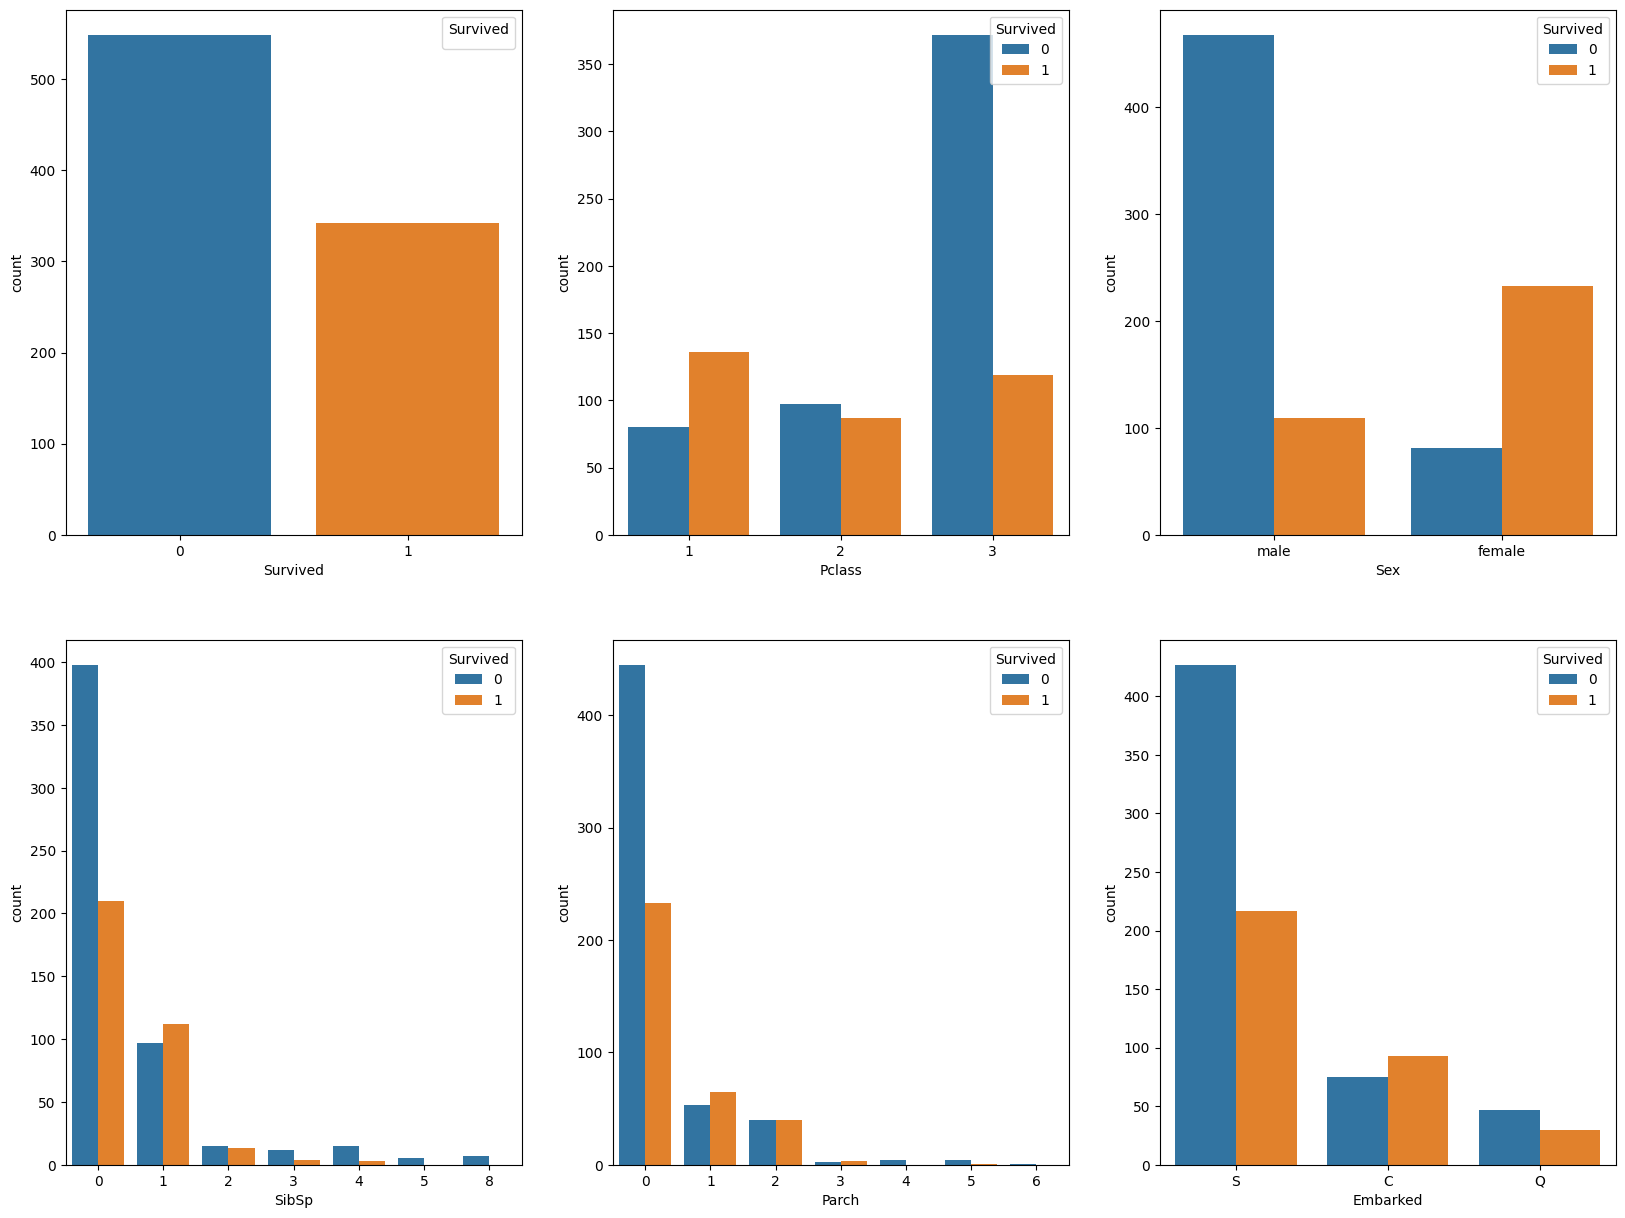

In [256]:
fig,ax = plt.subplots(2,3,figsize=(20,15))
sns.countplot(data=training,x='Survived',ax=ax[0][0])
sns.countplot(data=training,x='Pclass',hue='Survived',ax=ax[0][1])
sns.countplot(data=training,x='Sex',hue='Survived',ax=ax[0][2])
sns.countplot(data=training,x='SibSp',hue='Survived',ax=ax[1][0])
sns.countplot(data=training,x='Parch',hue='Survived',ax=ax[1][1])
sns.countplot(data=training,x='Embarked',hue='Survived',ax=ax[1][2])
for axes in ax:
    for a in axes:
        a.legend(loc=1,title='Survived')


Tried to plot all categorical variables by count, with 'Survived' as the hue. From the first plot, majority of people did not survive. Going through the different variables, we can see that following interesting features:

- Most people in better Pclass have a higher survival rate (% of survived in Pclass of 1 > 2 > 3)
- More females survived than males
- Those with SibSp of 1 have the highest survival rate 
- Those with Parch of 1 have the highest survival rate 
- Those who embarked from C=Cherburg have a higher survival rate, followed by Q=Queenstown and S=Southampton. FYI, sequence of port calls was from Southampton > Cherburg > Queenstown.

Let us try to take a look at the continuous features, Age and Fares.

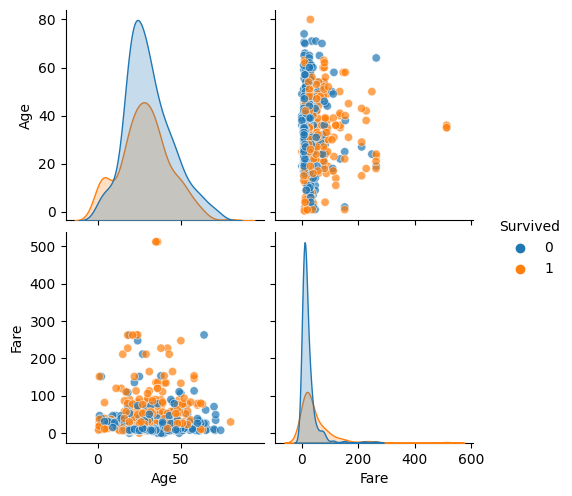

In [257]:
sns.pairplot(data=training[['Age','Survived','Fare']],hue='Survived',plot_kws={'alpha':0.7})

In [258]:
training.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Does not seem to have any strong correlations between 'Survived', 'Age' and 'Fare'

## Feature Engineering

We can further improve the model by adding in feature. For example, we could probably include the titles of each person as a feature. We can extract the titles of each person from their name using regular expressions


In [259]:
import re
training['Title_Name']=training['Name'].str.extract(r',\s(\w+)\.',flags=re.IGNORECASE)
training['Title_Name'].value_counts(dropna=False) #all titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
NaN           1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title_Name, dtype: int64

A quick search shows that some of the more obscure abbreviations are french titles:
- Mlle = mademoiselle
- Mme = Madame

We will be replace Mlle with Miss, Mme with Mrs. Also, to minimise the number of categories, we will be grouping all other categories after top 5 categories as 'Others'

In [260]:
training['Title_Name'].replace({'Mlle':'Miss','Mme':'Mrs',np.nan:'Others'},inplace=True)

replacement = list(training['Title_Name'].value_counts().index[4:])
new_value = ['Others' for x in replacement]

training['Title_Name'].replace(to_replace=replacement,value=new_value,inplace=True)

In [261]:
# Adding of feature for test data for use in predictions
test['Title_Name']=test['Name'].str.extract(r',\s(\w+)\.',flags=re.IGNORECASE)
test['Title_Name'].replace({'Mlle':'Miss','Mme':'Mrs',np.nan:'Others'},inplace=True)

replacement = list(test['Title_Name'].value_counts().index[4:])
new_value = ['Others' for x in replacement]

test['Title_Name'].replace(to_replace=replacement,value=new_value,inplace=True)

## Outliers

To remove or not to remove outliers? Firstly, we should differentiate between natural outliers and outilers that happened due to the mistake in the measurement or typographical errors. Of course, if we know that it is due to some mistakes, we should remove the outliers. If there are only a small proportion of outliers, we could also remove them. In this case, the fare outliers does not seem to be a mistake, and the number of outliers is significant. Hence, I will not be removing them. I will however keep the codes here for future use if required.

In [262]:
def remove_outliers(df,column:str,iqr_range=3):
    '''
    Remove outliers based in IQR, with default of any values outside 3 * IQR being removed

    Returns the indices of the df for which the values in the column is < or > IQR*3 of the 25th and 75th percentile
    
    '''

    percent_25 = np.percentile(df[column],25)
    percent_75 = np.percentile(df[column],75)
    IQR = percent_75 - percent_25

    return df.loc[~((df[column]<(percent_25-iqr_range*IQR)) | (df[column]>(percent_75+iqr_range*IQR)))]


## Fill NA values

Age and Embarked columns consist of some NA values. We can fill NA values based on the median of the age and the value which appears the most from Embarked. Normally, filling of NA values happens after train-test-split to avoid using testing data, but in this case as the training data is separated, we are able to do it now. 

Let's make use of sklearn SimpleImputer for the filling of NA values. We would also use the same strategy for x_test values

In [263]:
from sklearn.impute import SimpleImputer

In [264]:
imp_median = SimpleImputer(missing_values=np.nan,strategy='median',copy=False)
imp_freq = SimpleImputer(missing_values=np.nan,strategy='most_frequent',copy=False)

training['Age']=imp_median.fit_transform(training[['Age','Fare']])
training['Embarked']=imp_freq.fit_transform(training[['Embarked']])

## Feature selection, scaling and encoding

Before deploying our ML models, we would still be required to perform scaling and encoding of the variables. Categorical variables, such as Sex, would need to be one-hot-encoded as many ML techniques, such as Logistics Regression, are sensitive to such variables. Models employing continouous variables, such as Fares, would also be better off if we scale the data down to scale, either via min-max scaling or Z-score scaling. 

We would be performing MinMaxScaling for Age, Fares and OneHotEncoding for Sex,Pclass,Embarked and Title_Name

In [265]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer

In [266]:
features_to_retain = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked','Title_Name']
labels = 'Survived'

In [267]:
preprocessor = ColumnTransformer(
    [('continuous',MinMaxScaler(),['Age','Fare']),
    ('categories',OneHotEncoder(),['Pclass','Sex','Embarked','Title_Name'])],
    remainder='passthrough'
)

In [268]:
y_train = training[labels]
x_train= training[features_to_retain]

x_test= test[features_to_retain]

## Machine Learning Models

We would run a series of classifiers, with using 10 iterations of RandomSearchCV for efficiency in hyperparameter tunings. The classifiers are:
- Naive-Bayes
- Logistic Regression
- Decision Tree
- Random Forest 
- Adaboost
- Gradient Boost
- XGBoost
- SVM
- Neural Network (using tf.keras)

We would then compare the training metrics for these models as we do not have the testing labels.

In [269]:
def model_metrics(model,x_train,y_train):

    y_pred_train = model.predict(x_train)
    accuracy_train = metrics.accuracy_score(y_train,y_pred_train)
    f1_train = metrics.f1_score(y_train,y_pred_train)
    precision_train = metrics.precision_score(y_train,y_pred_train)
    recall_train = metrics.recall_score(y_train,y_pred_train)
    roc_auc_train = metrics.roc_auc_score(y_train,model.predict_proba(x_train)[:,1])
    ap_score_train = metrics.average_precision_score(y_train,model.predict_proba(x_train)[:,1])
    
    return [accuracy_train,f1_train,precision_train,recall_train,roc_auc_train,ap_score_train]

def plot_CM_ROC_PR(x_train,y_train,estimator,name):
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,6))

    cm = ConfusionMatrixDisplay.from_estimator(
        estimator,
        x_train,
        y_train,
        ax=ax1,
        cmap='Reds'
        # ,display_labels=['False','True']
    )
    ax1.set_title(f'Confusion Matrix of {name} model:')

    RocCurveDisplay.from_estimator(estimator,x_train,y_train,name=name,ax=ax2,color='orange')
    ax2.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax2.set_xlim([-0.05,1.05])
    ax2.set_ylim([-0.05,1.05])
    ax2.set_title('ROC Curve')
    
    baseline_pr = len(y_train[y_train==1]) / len(y_train)

    PrecisionRecallDisplay.from_estimator(estimator,x_train,y_train,name=name,ax=ax3,color='orange')
    ax3.plot([0, 1], [baseline_pr, baseline_pr], color="navy", lw=2, linestyle="--")
    ax3.set_xlim([-0.05,1.05])
    ax3.set_ylim([-0.05,1.05])
    ax3.set_title('Precision Recall Curve')

    plt.show()

In [270]:
#collapse
model_params = {

    #Multinomial Naive-Bayes
    'MNB':{
        'model': MultinomialNB(),
        'params': {
            'MNB__alpha':[0.01,0.1]
            }
    },

    # Logistic Regression
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'LogisticRegression__penalty':['l1','l2'],
            'LogisticRegression__solver':['liblinear','saga','lbfgs'],
            'LogisticRegression__C':[0.0001,0.001,0.01,0.1,1],
            'LogisticRegression__max_iter':[1000]
        }
    },
    
    # Decision Tree
    'DT': {
        'model': DecisionTreeClassifier(),
        'params': {
             'DT__criterion':['gini','entropy','log_loss'],
             'DT__splitter':['best','random'],
             'DT__max_depth':[2,4,6,8,10],
             'DT__min_samples_split':[2,4,6],
             'DT__min_samples_leaf':[2,4,6],
             'DT__max_features':['sqrt','log2']
        }
    },

    # Random Forest
    'RandomForest': {
        'model': ensemble.RandomForestClassifier(),
        'params': {
             'RandomForest__n_estimators':[50,100,150],
             'RandomForest__criterion':['gini','entropy'],
             'RandomForest__min_samples_split':[2,4,6,8,10],
             'RandomForest__min_samples_leaf':[2,4,6],
             'RandomForest__max_features':['sqrt','log2'],
             'RandomForest__oob_score':[True]
        }
    },

    #Ada-boost
    'Adaboost':{
        'model':ensemble.AdaBoostClassifier(),
        'params': {
             'Adaboost__base_estimator':[DecisionTreeClassifier()],
             'Adaboost__n_estimators':[50,100,150],
             'Adaboost__learning_rate':[0.1,1],
             'Adaboost__base_estimator__max_depth':[3,4,5],
             'Adaboost__algorithm':['SAMME.R','SAMME']
            }
    },
    
    # GradientBoosting
    'GradientBoosting': {
        'model': ensemble.GradientBoostingClassifier(),
        'params': {
             'GradientBoosting__loss':['log_loss','exponential'],
             'GradientBoosting__learning_rate':[0.01,0.1,1],
             'GradientBoosting__n_estimators':[50,100,150],
             'GradientBoosting__subsample':[0.1,0.5,1],
             'GradientBoosting__min_samples_split':[2,10,20],
             'GradientBoosting__min_samples_leaf':[1,5,10],
             'GradientBoosting__max_depth':[3,5,10]
        }
    },

    # XGBoost
        'XGBoost': {
            'model': XGBClassifier(),
            'params': {
                'XGBoost__n_estimators': [int(x) for x in np.linspace(100,2000,5)],
                'XGBoost__learning_rate': [0.1, 0.3, 0.5, 0.7, 1.0],
                'XGBoost__min_child_weight': [1, 5, 10],
                'XGBoost__gamma': [0.5, 1, 1.5, 2, 5],
                'XGBoost__subsample': [0.6, 0.8, 1.0],
                'XGBoost__colsample_bytree': [0.6, 0.8, 1.0],
                'XGBoost__max_depth': [3, 4, 5]
            }
        },

    # SVM
        'SVM': {
            'model': svm.SVC(),
            'params': {
                'SVM__probability':[True],
                'SVM__C': [0.001,0.01,0.1,1],
                'SVM__kernel': ['linear', 'poly','rbf']
            }
        }

    # # ,MLP
    #     'MLP': {
    #         'model': MLPClassifier(),
    #         'params': {
    #             'MLP__hidden_layer_sizes':[(32,16),(64,32)],
    #             'MLP__activation':['relu','logistic'],
    #             'MLP__learning_rate':['constant'],
    #             'MLP__learning_rate_init':[0.001,0.01],
    #             'MLP__early_stopping':[True]
    #         }
    #     }
}

In [271]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('continuous', MinMaxScaler(), ['Age', 'Fare']),
                                ('categories', OneHotEncoder(),
                                 ['Pclass', 'Sex', 'Embarked', 'Title_Name'])])

In [272]:
si = SimpleImputer(strategy='median')


In [273]:
pd.DataFrame(si.fit_transform(x_train[['Age']])).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       891 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


In [274]:
pd.DataFrame(preprocessor.fit_transform(x_train)).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       891 non-null    float64
 1   1       891 non-null    float64
 2   2       891 non-null    float64
 3   3       891 non-null    float64
 4   4       891 non-null    float64
 5   5       891 non-null    float64
 6   6       891 non-null    float64
 7   7       891 non-null    float64
 8   8       891 non-null    float64
 9   9       891 non-null    float64
 10  10      891 non-null    float64
 11  11      891 non-null    float64
 12  12      891 non-null    float64
 13  13      891 non-null    float64
 14  14      891 non-null    float64
 15  15      891 non-null    float64
 16  16      891 non-null    float64
dtypes: float64(17)
memory usage: 118.5 KB


In [275]:
#collapse_output

models_to_tune = list(model_params.keys())
best_models={}
results_all = []

for n in range(len(models_to_tune)):
    pipe = Pipeline(
        steps=[('preprocessor', preprocessor), (models_to_tune[n], model_params[models_to_tune[n]]['model'])])

    rs = RandomizedSearchCV(pipe,
                            param_distributions=model_params[models_to_tune[n]]['params'],
                            n_iter=20,
                            scoring='accuracy',
                            random_state=1987,
                            verbose=0,
                            cv=StratifiedKFold(n_splits=5))

    print(f'Processing for {models_to_tune[n]}...')
    rs.fit(x_train, y_train)
    best_models[models_to_tune[n]]=rs.best_estimator_
    y_pred = rs.predict(x_train)

    results = [models_to_tune[n]] + model_metrics(rs.best_estimator_,x_train,y_train)
    results_all.append(results)

    # tn, fp, fn, tp=metrics.confusion_matrix(y_train,y_pred).ravel()

Processing for MNB...


C:\Users\Thomas Lim\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Processing for LogisticRegression...


C:\Users\Thomas Lim\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Thomas Lim\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Thomas Lim\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Thomas Lim\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_

Processing for DT...
Processing for RandomForest...
Processing for Adaboost...
Processing for GradientBoosting...
Processing for XGBoost...
Processing for SVM...


C:\Users\Thomas Lim\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


## Using tfkeras for Neural Network (MLP)

In [276]:
def create_model(my_learning_rate,layers=[20,12]):

    model = tf.keras.models.Sequential()

    #hidden layers
    for index,layer in enumerate(layers):
        model.add(tf.keras.layers.Dense(units=layer,activation='relu',name = f'hidden{index}'))
    
    #output layer
    model.add(tf.keras.layers.Dense(units=1,activation='sigmoid',name='output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss='binary_crossentropy',metrics=['accuracy','AUC','Precision','Recall'])
      
    return model

def train_model(model,x_train_normalised,y_train,epochs,batch_size,validation_split,cb_list):

    history = model.fit(x=x_train_normalised, y=y_train, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split,callbacks=cb_list)

    return history

def plot_curve(hist):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

    epochs = hist.epoch
    f, ax = plt.subplots(ncols=2, figsize=(20,12))
    ax[0].plot(epochs, hist.history['accuracy'], label='Training Accuracy')
    ax[0].plot(epochs, hist.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].set_xticks(epochs)
    
    ax[1].plot(epochs, hist.history['loss'], label='Training Loss')
    ax[1].plot(epochs, hist.history['val_loss'], label='Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].set_xticks(epochs)
    plt.show()

def plot_CM_ROC_PR_NN(x_train,y_train,my_model,name):
    '''
    x_train,y_train: self explanatory
    my_model: need predict and predict_proba method to get predict proba and classes
    name: Name of classifier
    '''
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,6))

    if name=='NN':
        probs = my_model.predict(x_train) #use this for NN to get probability as estimator.predict for sklearn gives us the actual classes
    else:
        probs = my_model.predict_proba(x_train)
        
    y_pred = probs > 0.5 #default threshold at 0.5

    ConfusionMatrixDisplay.from_predictions(y_train,y_pred,ax=ax1,cmap='Reds')
    ax1.set_title(f'Confusion Matrix of {name} model:')

    fpr,tpr,_ = metrics.roc_curve(y_train,probs)
    roc_auc = metrics.auc(fpr, tpr)
    ax2.plot(fpr, tpr,color='orange')
    ax2.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax2.legend([f'NN (AUC = {roc_auc:.2f})'],loc='lower right')
    ax2.set(xlabel='False Positive Rate',ylabel='True Positive Rate')
    ax2.set_xlim([-0.05,1.05])
    ax2.set_ylim([-0.05,1.05])
    ax2.set_title('ROC Curve')
    
    baseline_pr = len(y_train[y_train==1]) / len(y_train)
    average_precision = average_precision_score(y_train, probs)

    precision, recall, _ = precision_recall_curve(y_train, probs)
    ax3.plot(recall, precision, color='orange')
    ax3.plot([0, 1], [baseline_pr, baseline_pr], color="navy", lw=2, linestyle="--")
    ax2.set(xlabel='Recall',ylabel='Precision')
    ax3.legend([f'NN (AP = {average_precision:.2f})'],loc='lower right')
    ax3.set_xlim([-0.05,1.05])
    ax3.set_ylim([-0.05,1.05])
    ax3.set_title('Precision-Recall Curve')

def model_metrics_nn(probs,y_train,y_pred):
    
    #for NN models using keras
    accuracy_train = metrics.accuracy_score(y_train,y_pred)
    f1_train = metrics.f1_score(y_train,y_pred)
    precision_train = metrics.precision_score(y_train,y_pred)
    recall_train = metrics.recall_score(y_train,y_pred)
    roc_auc_train = metrics.roc_auc_score(y_train,probs)
    ap_score_train = metrics.average_precision_score(y_train,probs)
    
    return [accuracy_train,f1_train,precision_train,recall_train,roc_auc_train,ap_score_train]

In [277]:
#collapse_output
#normalise/scaling

pipe2 = Pipeline(steps=[('preprocessor', preprocessor)])
x_train_nn = pipe2.fit_transform(x_train)
y_train_nn = y_train.values

#hyperparameters to use

learning_rate = 0.003
epochs = 100
batch_size = 200
validation_split = 0.3

#set early stop

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=10,verbose=1,mode="auto",baseline=None,restore_best_weights=False,)
mc = tf.keras.callbacks.ModelCheckpoint("best_model.h5",monitor="val_accuracy",mode="auto",verbose=1,save_best_only=True,)

#creating model
my_model = create_model(learning_rate)

#fitting/training model
hist = train_model(my_model,x_train_nn,y_train_nn,epochs,batch_size,validation_split,[es,mc])

#load the best model from early stoppage
my_model = tf.keras.models.load_model('best_model.h5')

Epoch 1/100
1/4 [======>.......................] - ETA: 2s - loss: 0.7046 - accuracy: 0.5700 - auc: 0.5860 - precision: 0.4028 - recall: 0.4028
Epoch 1: val_accuracy improved from -inf to 0.64179, saving model to best_model.h5
4/4 [==============================] - 1s 144ms/step - loss: 0.6918 - accuracy: 0.5602 - auc: 0.5783 - precision: 0.4239 - recall: 0.3171 - val_loss: 0.6396 - val_accuracy: 0.6418 - val_auc: 0.7232 - val_precision: 0.5000 - val_recall: 0.1458
Epoch 2/100
1/4 [======>.......................] - ETA: 0s - loss: 0.6586 - accuracy: 0.5900 - auc: 0.7043 - precision: 0.5833 - recall: 0.1628
Epoch 2: val_accuracy improved from 0.64179 to 0.65672, saving model to best_model.h5
4/4 [==============================] - 0s 16ms/step - loss: 0.6358 - accuracy: 0.6292 - auc: 0.7339 - precision: 0.6364 - recall: 0.1423 - val_loss: 0.5928 - val_accuracy: 0.6567 - val_auc: 0.8052 - val_precision: 1.0000 - val_recall: 0.0417
Epoch 3/100
1/4 [======>.......................] - ETA: 0s

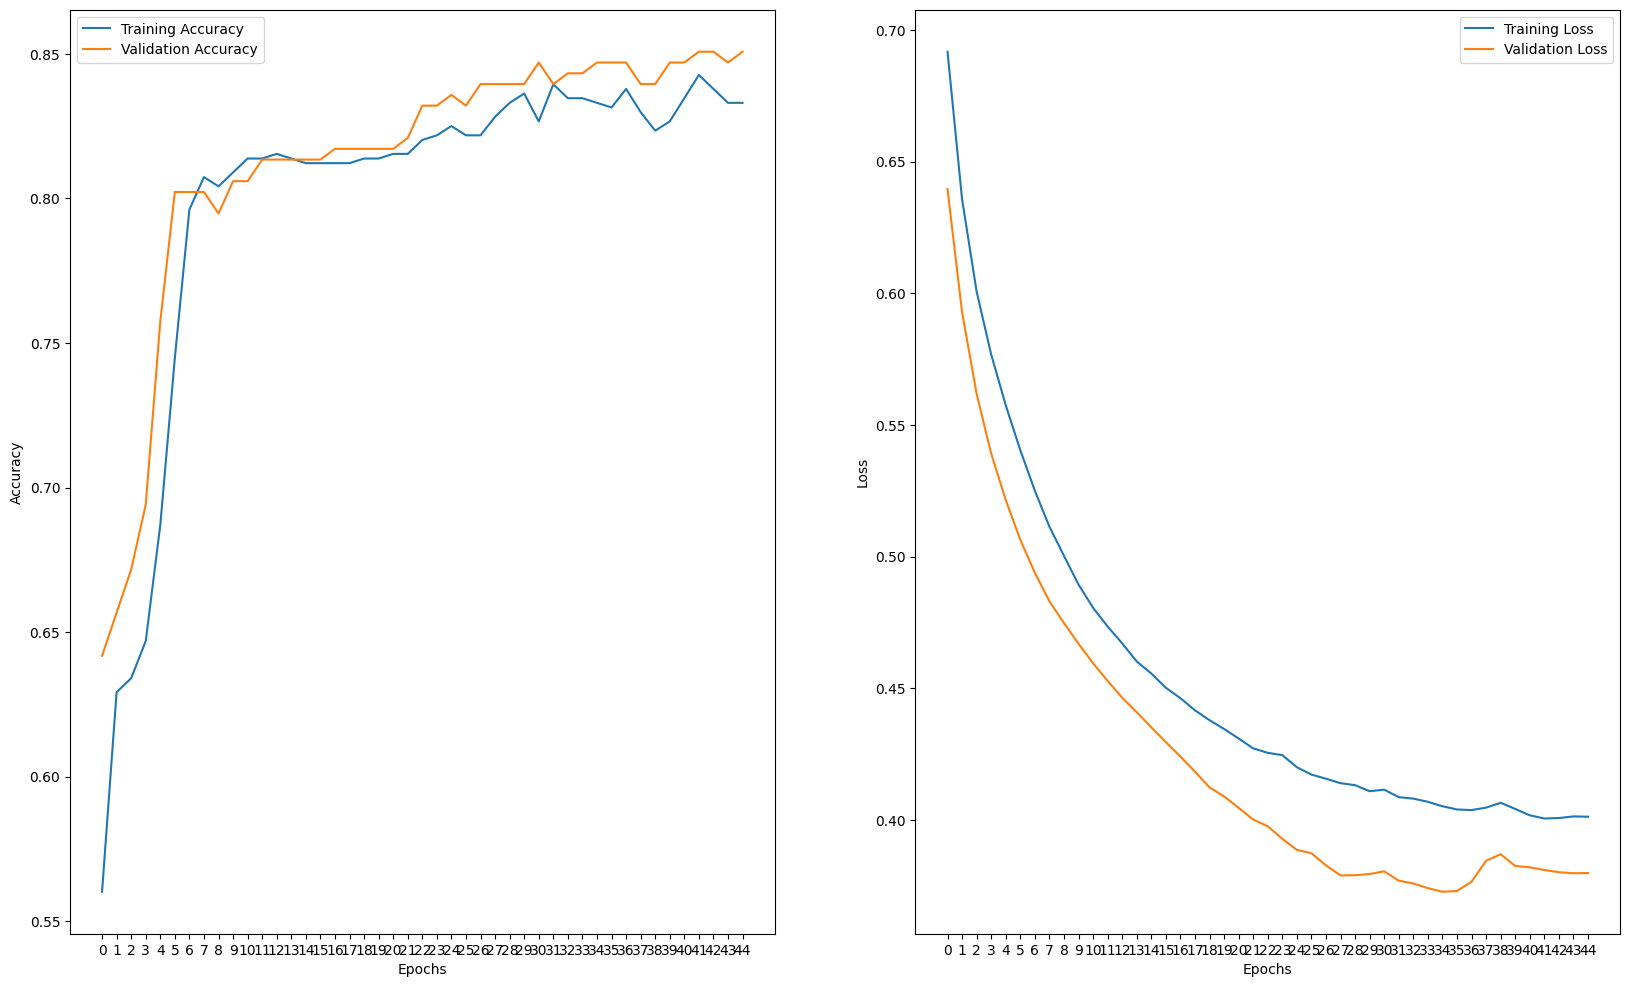

In [278]:
#collapse_output
plot_curve(hist)

In [279]:
probs = my_model.predict(x_train_nn)
y_pred = np.where(probs > 0.5,1,0).flatten()

nn_metrics = model_metrics_nn(probs,y_train,y_pred)
results_all.append(['NN']+nn_metrics)

28/28 [==============================] - 0s 1ms/step


## Final metrics and graphs for all models

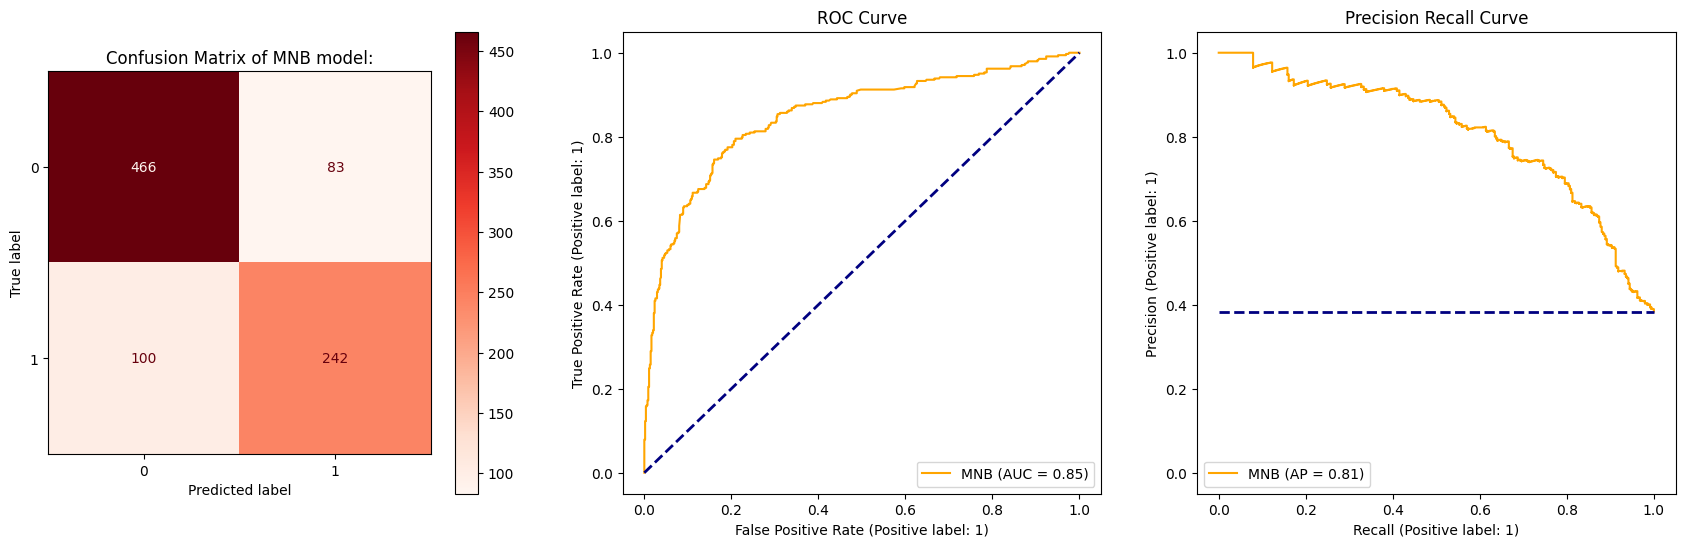

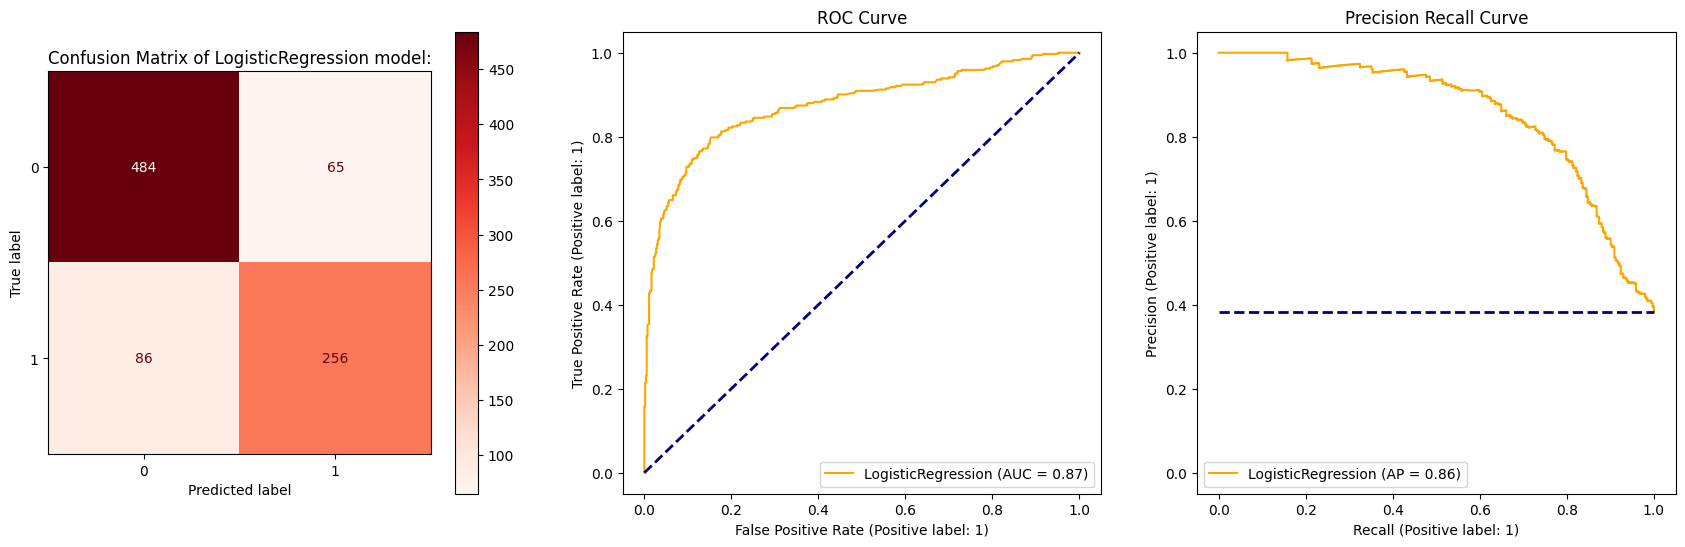

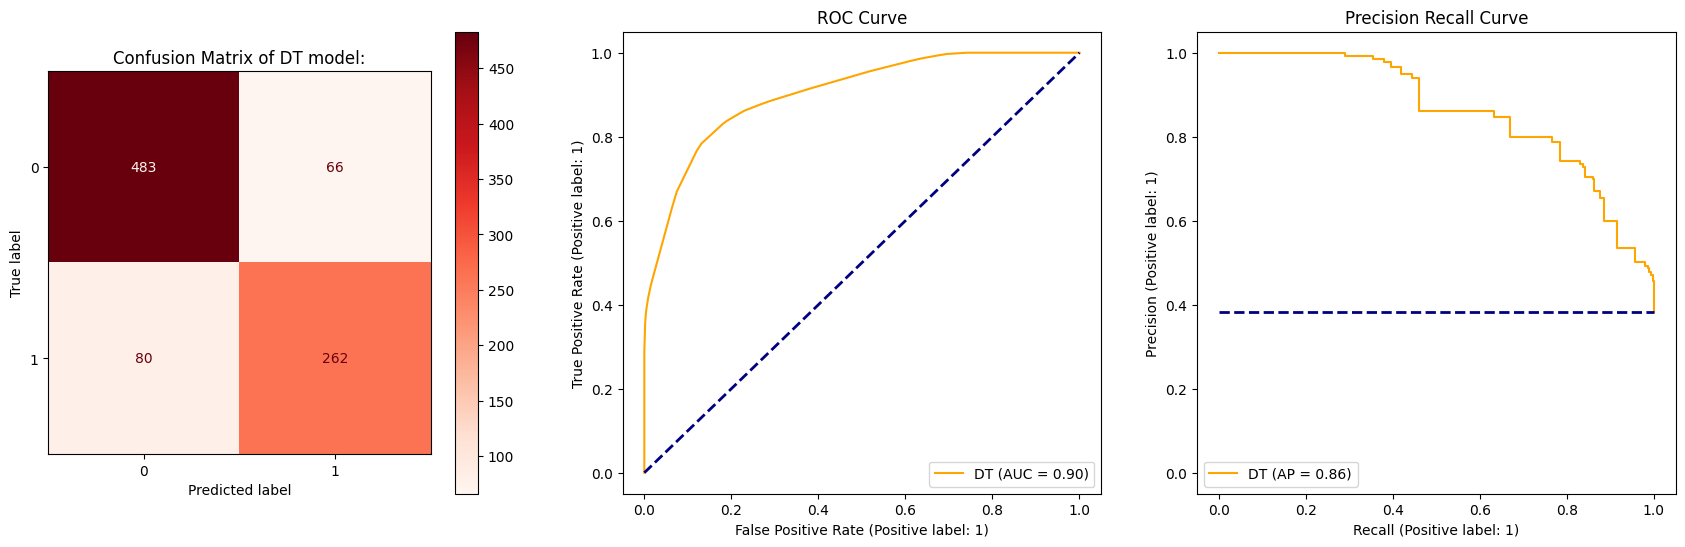

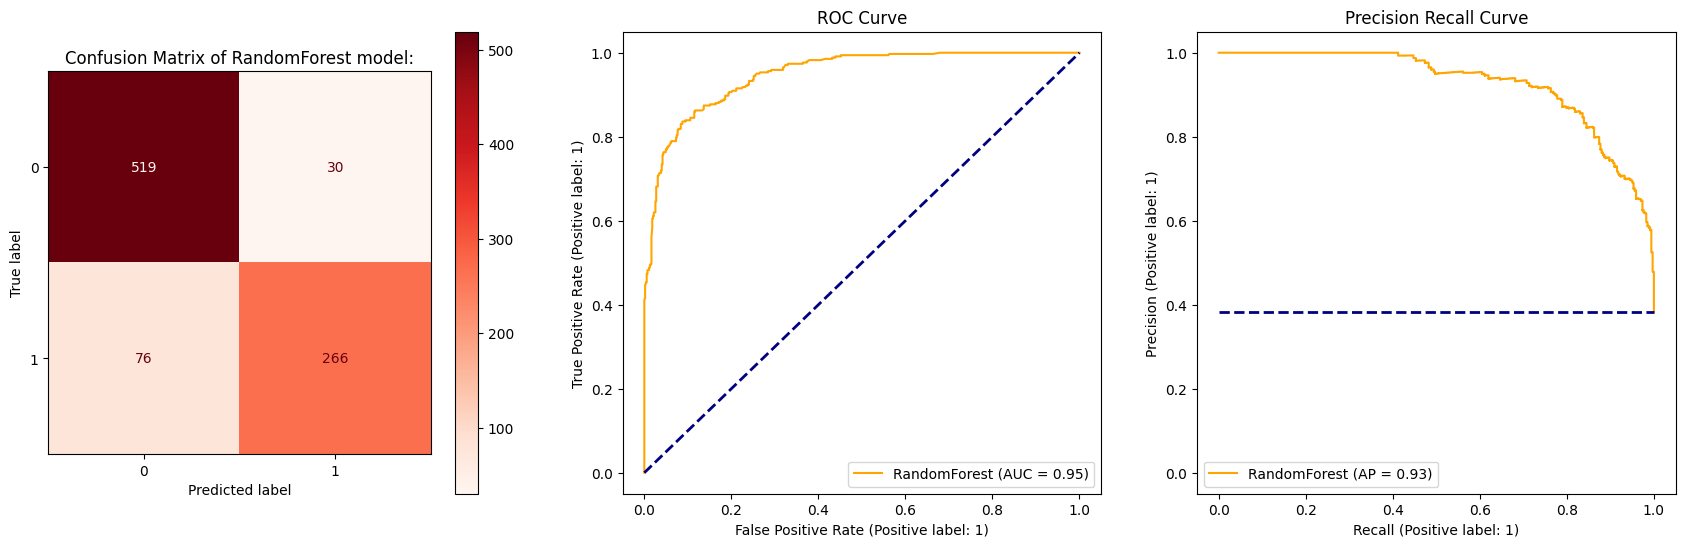

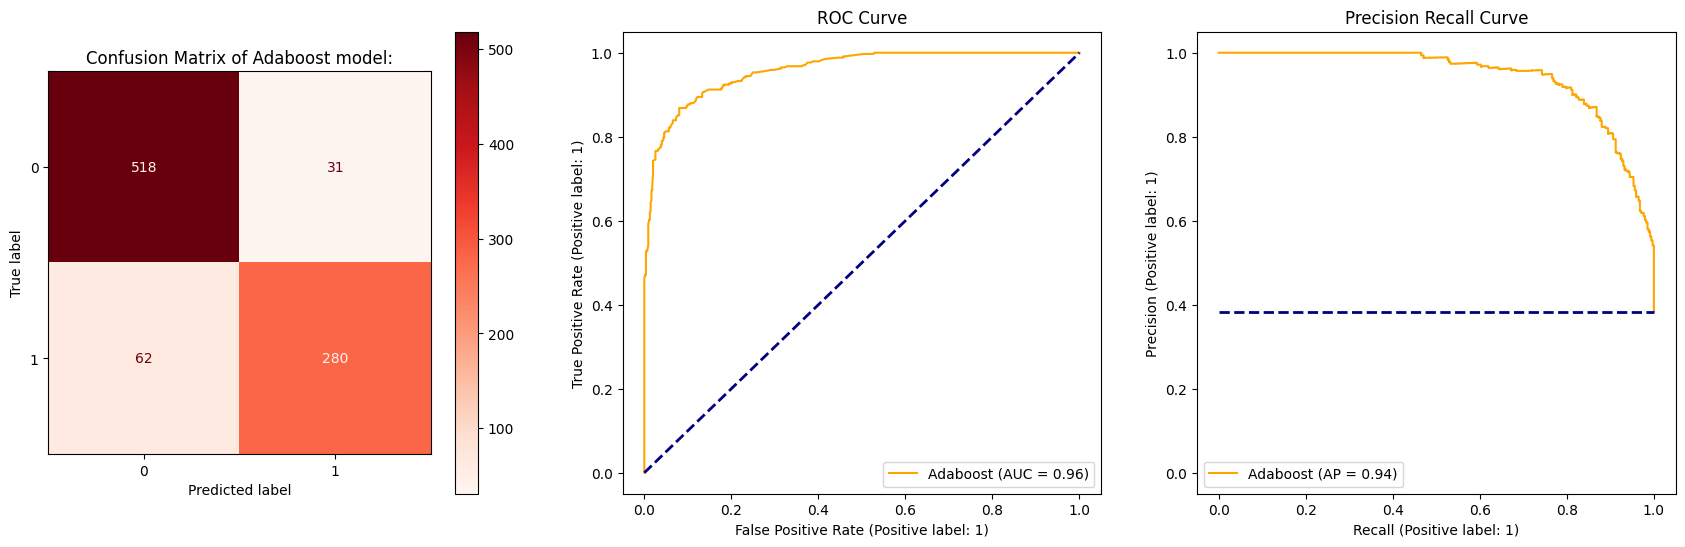

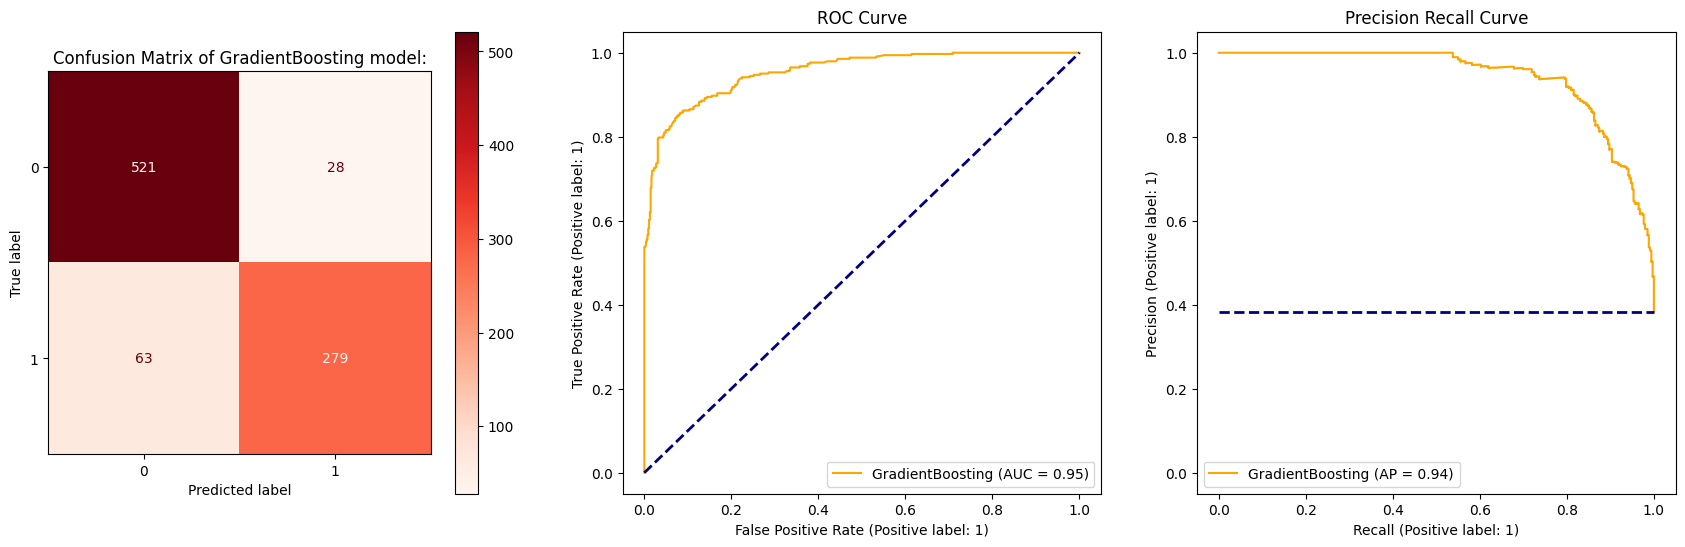

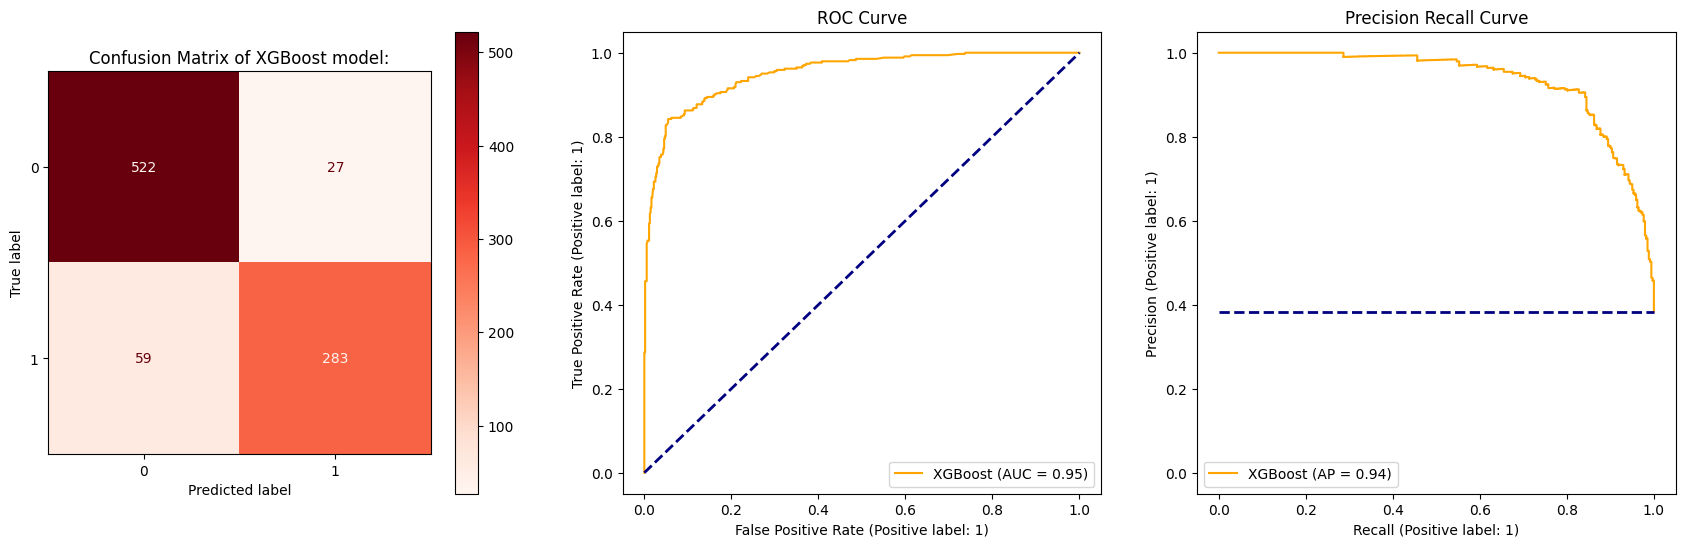

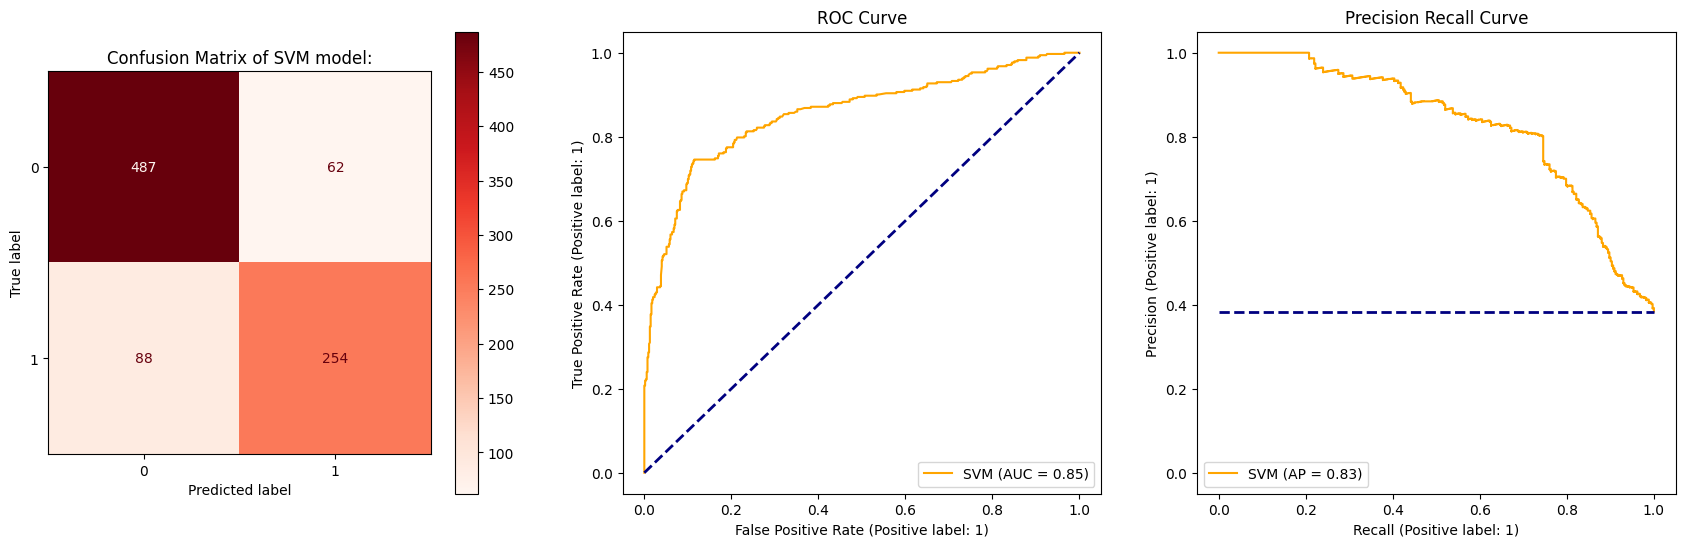

28/28 [==============================] - 0s 1ms/step


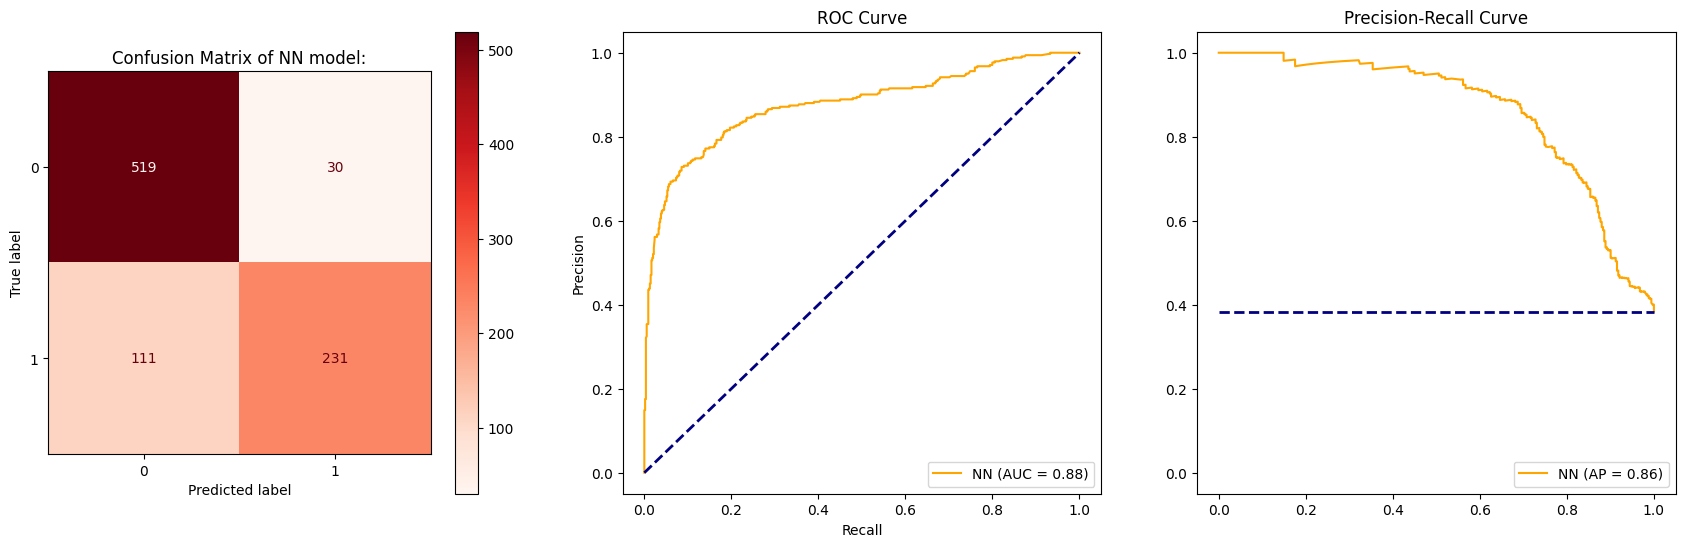

In [280]:
#collapse_output
for n in range(len(models_to_tune)):
    plot_CM_ROC_PR(x_train,y_train,best_models[models_to_tune[n]],models_to_tune[n])
plot_CM_ROC_PR_NN(x_train_nn,y_train,my_model,'NN')

In [281]:
results_df = pd.DataFrame(results_all,columns=['model','accuracy','f1','precision','recall','auc roc','auc pr'])
results_df

,model,accuracy,f1,precision,recall,auc roc,auc pr
0,MNB,0.794613,0.725637,0.744615,0.707602,0.850076,0.810483
1,LogisticRegression,0.830527,0.772247,0.797508,0.748538,0.874985,0.857189
2,DT,0.836139,0.782090,0.798780,0.766082,0.902838,0.860520
3,RandomForest,0.881033,0.833856,0.898649,0.777778,0.947789,0.927177
4,Adaboost,0.895623,0.857580,0.900322,0.818713,0.958257,0.943612
5,GradientBoosting,0.897868,0.859784,0.908795,0.815789,0.954359,0.941798
6,XGBoost,0.903479,0.868098,0.912903,0.827485,0.951206,0.935901
7,SVM,0.831650,0.772036,0.803797,0.742690,0.854944,0.829743
8,NN,0.841751,0.766169,0.885057,0.675439,0.876562,0.862161


<BarContainer object of 17 artists>

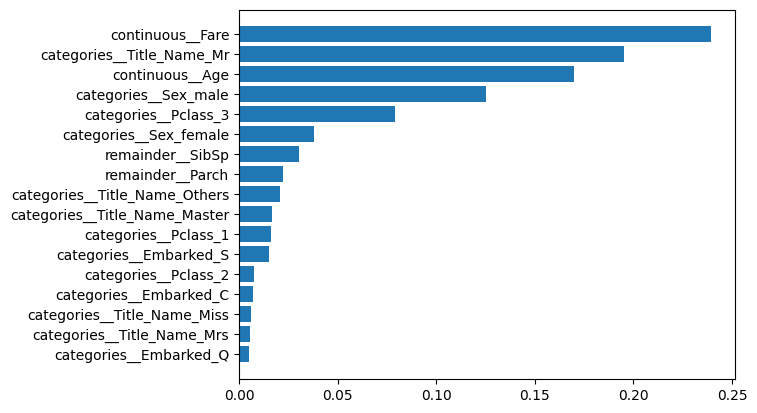

In [ ]:
feat_importances = best_models['GradientBoosting'][-1].feature_importances_
features = best_models['GradientBoosting'][:-1].get_feature_names_out()
sorted_index = feat_importances.argsort()
plt.barh(features[sorted_index],feat_importances[sorted_index])

In [311]:
results_df.iloc[]

,model,accuracy,f1,precision,recall,auc roc,auc pr
0,MNB,0.794613,0.725637,0.744615,0.707602,0.850076,0.810483
1,LogisticRegression,0.830527,0.772247,0.797508,0.748538,0.874985,0.857189
2,DT,0.836139,0.782090,0.798780,0.766082,0.902838,0.860520
3,RandomForest,0.881033,0.833856,0.898649,0.777778,0.947789,0.927177
4,Adaboost,0.895623,0.857580,0.900322,0.818713,0.958257,0.943612
5,GradientBoosting,0.897868,0.859784,0.908795,0.815789,0.954359,0.941798
6,XGBoost,0.903479,0.868098,0.912903,0.827485,0.951206,0.935901
7,SVM,0.831650,0.772036,0.803797,0.742690,0.854944,0.829743
8,NN,0.841751,0.766169,0.885057,0.675439,0.876562,0.862161


In [318]:
top2model = results_df.iloc[results_df['auc roc'].sort_values(ascending=False).index[:2]]['model'].values

In [320]:
top2model[0]

'Adaboost'

In [321]:
## Voting classifier

from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[('0',best_models[top2model[0]]),('1',best_models[top2model[1]])],voting='soft')

In [323]:
x_test[['Age','Fare']]=imp_median.fit_transform(x_test[['Age','Fare']])
x_test['Embarked']=imp_freq.fit_transform(x_test[['Embarked']])

C:\Users\Thomas Lim\AppData\Local\Temp\ipykernel_94736\2208434360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[['Age','Fare']]=imp_median.fit_transform(x_test[['Age','Fare']])
C:\Users\Thomas Lim\AppData\Local\Temp\ipykernel_94736\2208434360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['Embarked']=imp_freq.fit_transform(x_test[['Embarked']])


In [325]:
#generate submissions
test['Survived']=vc.predict(x_test)
test[['PassengerId','Survived']].to_csv('submissions.csv',index=False)

#Submitted with 76.6% score!